In [1]:
import sys

sys.path.insert(0, '..')

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

In [ ]:
"""
We used 16 features from Gaia EDR3, 2MASS and AllWISE. These
include the EDR3 G, BP, RP magnitudes and the associated uncertainties, the 𝐵𝑃−𝑅𝑃 color, the 𝐵𝑃−𝑅𝑃 excess factor, signal-to-noise
ratios in G and BP, the renormalized unit weight error (RUWE), the
𝐽 − 𝐾𝑠 color, the absolute 𝑊𝑅𝑃 magnitude and the absolute 𝑊𝐽 𝐾
magnitude. The EDR3 signal-to-noise ratios are essentially the ratio of the observed flux divided by the error in the flux. As noted
earlier, the EDR3 photometric uncertainties and flux errors encode
information about the photometric variability of stars. We also used
the absolute, “reddening-free” Wesenheit magnitudes (Madore 1982;
Lebzelter et al. 2018)
𝑊𝑅𝑃 = 𝑀RP − 1.3(𝐵𝑃 − 𝑅𝑃) , (1)
and
𝑊𝐽 𝐾 = 𝑀Ks − 0.686(𝐽 − 𝐾𝑠) (2)
and the probabilistic EDR3 distances from Bailer-Jones et al. (2021)
"""

In [70]:
def train_epoch():
    model.train()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == y).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += y.size(0)

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions
    
def val_epoch():
    model.eval()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X, y in tqdm(val_dataloader):
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == y).sum().item()
    
            total_correct_predictions += correct_predictions
            total_predictions += y.size(0)

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [41]:
METADATA_COLS = [
    'mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic',
    'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe'
]

In [80]:
class MetaVDataset(Dataset):
    def __init__(self, file, split='train', classes=None, min_samples=None, max_samples=None,
                 random_seed=42, verbose=True):
        self.df = pd.read_csv(file)
        self.metadata_cols = METADATA_COLS
        self.df = self.df[self.metadata_cols + ['edr3_source_id', 'variable_type']]

        self.split = split
        self.verbose = verbose
        self.classes = classes
        self.min_samples = min_samples
        self.max_samples = max_samples

        self.random_seed = random_seed
        np.random.seed(random_seed)

        self._drop_nan()
        self._drop_duplicates()
        self._filter_classes()
        self._limit_samples()
        self._split()
        self._normalize()

        self.id2target = {i: x for i, x in enumerate(sorted(self.df['variable_type'].unique()))}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)

    def _drop_nan(self):
        if self.verbose:
            print('Dropping nan values...', end=' ')

        self.df.dropna(axis=0, how='any', inplace=True)

        if self.verbose:
            print(f'Done. Left with {len(self.df)} rows.')

    def _drop_duplicates(self):
        if self.verbose:
            print('Dropping duplicated values...', end=' ')

        self.df.drop_duplicates(subset=['edr3_source_id'], keep='last', inplace=True)

        if self.verbose:
            print(f'Done. Left with {len(self.df)} rows.')

    def _filter_classes(self):
        if self.classes:
            if self.verbose:
                print(f'Leaving only classes: {self.classes}... ', end='')

            self.df = self.df[self.df['variable_type'].isin(self.classes)]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _limit_samples(self):
        if self.max_samples or self.min_samples:
            if self.verbose:
                print(f'Removing objects that have more than {self.max_samples} or less than {self.min_samples} '
                      f'samples... ', end='')

            value_counts = self.df['variable_type'].value_counts()

            if self.min_samples:
                classes_to_remove = value_counts[value_counts < self.min_samples].index
                self.df = self.df[~self.df['variable_type'].isin(classes_to_remove)]

            if self.max_samples:
                classes_to_limit = value_counts[value_counts > self.max_samples].index
                for class_type in classes_to_limit:
                    class_indices = self.df[self.df['variable_type'] == class_type].index
                    indices_to_keep = np.random.choice(class_indices, size=self.max_samples, replace=False)
                    self.df = self.df.drop(index=set(class_indices) - set(indices_to_keep))

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _split(self):
        unique_ids = self.df['edr3_source_id'].unique()
        train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=self.random_seed)
        val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=self.random_seed)

        if self.split == 'train':
            self.df = self.df[self.df['edr3_source_id'].isin(train_ids)]
        elif self.split == 'val':
            self.df = self.df[self.df['edr3_source_id'].isin(val_ids)]
        elif self.split == 'test':
            self.df = self.df[self.df['edr3_source_id'].isin(test_ids)]
        else:
            print('Split is not train, val, or test. Keeping the whole dataset')

        if self.verbose:
            print(f'{self.split} split is selected: {len(self.df)} objects left.')

    def _normalize(self):
        if self.split == 'train':
            self.scaler = StandardScaler()
            self.scaler.fit(self.df[self.metadata_cols])
            joblib.dump(self.scaler, 'scaler.pkl')
        else:
            self.scaler = joblib.load('scaler.pkl')

        self.df[self.metadata_cols] = self.scaler.transform(self.df[self.metadata_cols])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        X = el[self.metadata_cols].values.astype(np.float32)
        y = self.target2id[el['variable_type']]

        return X, y

In [65]:
class MetaClassifier(nn.Module):
    def __init__(self, input_dim=36, hidden_dim=128, num_classes=15):
        super(MetaClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [81]:
file = '/home/mariia/AstroML/data/asassn/asassn_catalog_full.csv'
train_dataset = MetaVDataset(file, split='train', classes=None, min_samples=5000, max_samples=20000, random_seed=42, verbose=True)
val_dataset = MetaVDataset(file, split='val', classes=None, min_samples=5000, max_samples=20000, random_seed=42, verbose=True)

Dropping nan values... Done. Left with 452456 rows.
Dropping duplicated values... Done. Left with 448995 rows.
Removing objects that have more than 20000 or less than 5000 samples... 147435 objects left.
train split is selected: 117948 objects left.
Dropping nan values... Done. Left with 452456 rows.
Dropping duplicated values... Done. Left with 448995 rows.
Removing objects that have more than 20000 or less than 5000 samples... 147435 objects left.
val split is selected: 14743 objects left.


In [95]:
train_dataset[4]

(array([ 0.56179976,  0.2129925 , -0.43258795,  0.6385682 ,  0.2219096 ,
        -0.8019077 ,  0.76432294,  0.3823347 , -0.01179562,  0.7440708 ,
         0.13428305, -0.54766864, -0.3642406 , -0.18289573, -0.36045888,
         0.06274398, -0.18897781, -0.22072479, -0.20897777,  0.9286148 ,
         0.06963129,  0.89413244,  0.09064825,  0.9109438 ,  0.04780296,
         0.91482997, -0.2702152 ,  0.9344173 ,  0.02068826,  0.46345294,
         0.5244172 , -0.5494919 , -0.75290334,  0.26712453, -0.25207636,
        -0.18005288], dtype=float32),
 5)

In [82]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [83]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using', device)

model = MetaClassifier(num_classes=train_dataset.num_classes)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

Using cuda:1


In [85]:
for i in range(20):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 16.99it/s]


Train Loss: 1.022 Acc: 0.63


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.86it/s]


Val Loss: 0.728 Acc: 0.75
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:52<00:00, 17.54it/s]


Train Loss: 0.793 Acc: 0.72


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.72it/s]


Val Loss: 0.661 Acc: 0.77
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.32it/s]


Train Loss: 0.739 Acc: 0.74


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.72it/s]


Val Loss: 0.624 Acc: 0.78
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 17.04it/s]


Train Loss: 0.711 Acc: 0.75


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.75it/s]


Val Loss: 0.61 Acc: 0.78
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:55<00:00, 16.56it/s]


Train Loss: 0.69 Acc: 0.76


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.47it/s]


Val Loss: 0.594 Acc: 0.79
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.27it/s]


Train Loss: 0.675 Acc: 0.76


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.17it/s]


Val Loss: 0.588 Acc: 0.79
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:55<00:00, 16.74it/s]


Train Loss: 0.665 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.95it/s]


Val Loss: 0.575 Acc: 0.8
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 16.78it/s]


Train Loss: 0.657 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.85it/s]


Val Loss: 0.567 Acc: 0.79
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 17.00it/s]


Train Loss: 0.648 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.58it/s]


Val Loss: 0.564 Acc: 0.79
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.34it/s]


Train Loss: 0.642 Acc: 0.77


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.77it/s]


Val Loss: 0.563 Acc: 0.79
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.18it/s]


Train Loss: 0.638 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.55it/s]


Val Loss: 0.553 Acc: 0.8
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 17.07it/s]


Train Loss: 0.635 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.52it/s]


Val Loss: 0.557 Acc: 0.8
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.30it/s]


Train Loss: 0.634 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.36it/s]


Val Loss: 0.551 Acc: 0.8
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 17.05it/s]


Train Loss: 0.628 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.46it/s]


Val Loss: 0.545 Acc: 0.8
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:53<00:00, 17.29it/s]


Train Loss: 0.626 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.68it/s]


Val Loss: 0.546 Acc: 0.8
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:55<00:00, 16.72it/s]


Train Loss: 0.624 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.33it/s]


Val Loss: 0.542 Acc: 0.81
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 16.86it/s]


Train Loss: 0.623 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.04it/s]


Val Loss: 0.542 Acc: 0.8
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 16.94it/s]


Train Loss: 0.618 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.25it/s]


Val Loss: 0.537 Acc: 0.81
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:54<00:00, 16.96it/s]


Train Loss: 0.618 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 18.67it/s]


Val Loss: 0.539 Acc: 0.81
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 922/922 [00:55<00:00, 16.56it/s]


Train Loss: 0.615 Acc: 0.78


100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.79it/s]

Val Loss: 0.536 Acc: 0.81


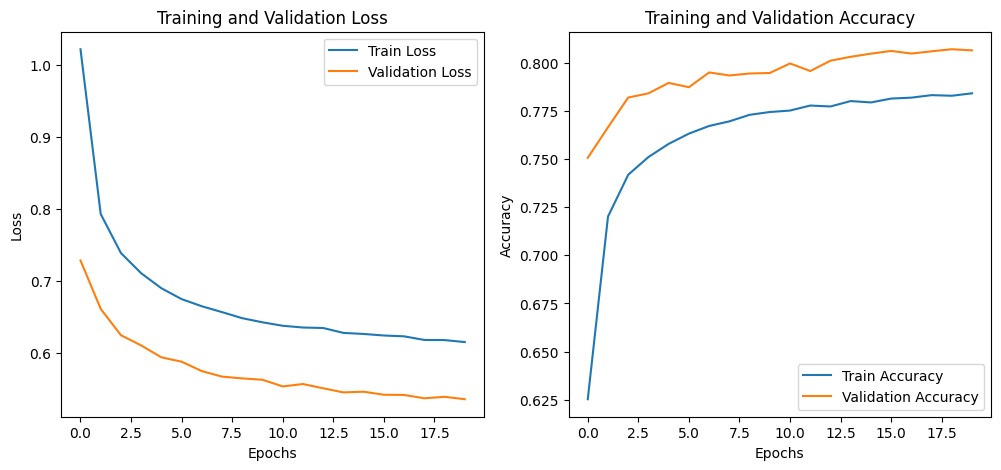

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [87]:
model.eval()

all_true_labels = []
all_predicted_labels = []

for X, y in tqdm(val_dataloader):
    with torch.no_grad():
        X = X.to(device)

        logits = model(X)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        all_true_labels.extend(y.numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

100%|███████████████████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.80it/s]


In [88]:
sum([all_true_labels[i] == all_predicted_labels[i] for i in range(len(all_predicted_labels))])/len(all_predicted_labels)

0.8064844332903751

Text(0.5, 1.0, 'Confusion Matrix - Percentages')

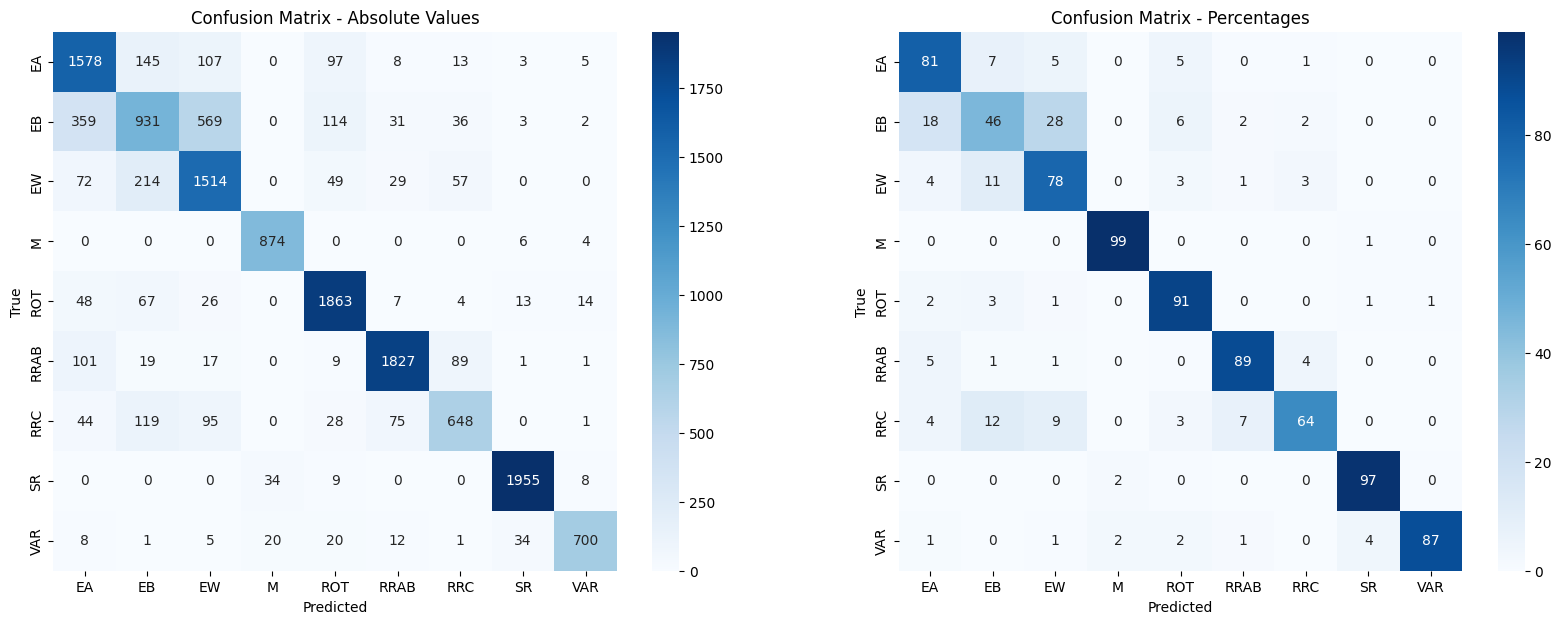

In [90]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate percentage values for confusion matrix
conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Get the labels from the id2target mapping
labels = [val_dataset.id2target[i] for i in range(len(conf_matrix))]

# Plot both confusion matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot absolute values confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Absolute Values')

# Plot percentage values confusion matrix
sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix - Percentages')

In [26]:
METADATA_COLS = [
    'mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic',
    'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe'
]

In [5]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/asassn_catalog_full.csv')

In [16]:
metadata_cols = ['mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic', 'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 
                 'phot_rp_mean_mag', 'e_phot_rp_mean_mag', 'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
                 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag', 'w2_mag', 'e_w2_mag', 'w3_mag', 'e_w3_mag', 'w4_mag', 'e_w4_mag', 
                 'j_k', 'w1_w2', 'w3_w4', 'apass_vmag', 'e_apass_vmag', 'apass_bmag', 'e_apass_bmag', 'apass_gpmag', 'e_apass_gpmag', 'apass_rpmag', 'e_apass_rpmag', 
                 'apass_ipmag', 'e_apass_ipmag', 'FUVmag', 'e_FUVmag', 'NUVmag', 'e_NUVmag', 'pm', 'ruwe']

In [17]:
df = df[metadata_cols + ['edr3_source_id', 'variable_type']]

In [22]:
df['variable_type'].value_counts().head(30)

variable_type
SR       204932
L         84019
EW        78503
VAR       63711
ROT:      55723
EA        50095
ROT       37012
RRAB      33165
EB        25932
RRC       11249
M         10329
YSO       10147
DSCT       4584
HADS       4428
GCAS       2021
GCAS:      1778
DCEP       1621
UG         1365
M:          922
UV          812
CWB         736
CWA         640
RRD         597
DCEPS       583
DSCT:       430
UGSU        313
SRD         229
LSP         185
RVA         152
HB          143
Name: count, dtype: int64

In [28]:
df = df[METADATA_COLS]

In [29]:
df.isna().sum() / len(df) * 100

mean_vmag               0.000000
amplitude               0.000000
period                 28.847963
phot_g_mean_mag         1.105868
e_phot_g_mean_mag       1.105868
lksl_statistic          0.000000
rfr_score               0.000000
phot_bp_mean_mag        2.983154
e_phot_bp_mean_mag      2.983154
phot_rp_mean_mag        2.946655
e_phot_rp_mean_mag      2.946655
bp_rp                   2.992897
parallax                2.403100
parallax_error          2.403100
parallax_over_error     2.403100
pmra                    2.403100
pmra_error              2.403100
pmdec                   2.403100
pmdec_error             2.403100
j_mag                   4.838337
e_j_mag                 5.423044
h_mag                   4.842118
e_h_mag                 5.580090
k_mag                   4.854623
e_k_mag                 6.806360
w1_mag                  3.772457
e_w1_mag                5.030573
w2_mag                  3.743811
e_w2_mag                4.985786
w3_mag                  3.849090
w4_mag    

In [31]:
df

,mean_vmag,amplitude,period,phot_g_mean_mag,e_phot_g_mean_mag,lksl_statistic,rfr_score,phot_bp_mean_mag,e_phot_bp_mean_mag,phot_rp_mean_mag,...,e_w1_mag,w2_mag,e_w2_mag,w3_mag,w4_mag,j_k,w1_w2,w3_w4,pm,ruwe
0,15.99,0.55,0.418185,15.935090,0.007574,0.48,0.75,16.152810,0.026184,15.583463,...,0.031,14.865,0.053,12.943,9.068,0.289,0.008,3.875,4.554,1.018
1,16.22,0.35,46.014660,16.127365,0.002822,0.90,0.54,17.515635,0.009061,14.967140,...,0.029,11.015,0.032,11.694,8.988,1.219,-0.331,2.706,3.727,1.015
2,14.76,0.44,284.777566,14.753926,0.007790,0.48,0.77,14.729215,0.010188,14.903267,...,0.027,14.229,0.035,13.028,9.317,0.104,0.348,3.711,1.467,0.985
3,15.30,0.43,NaN,15.531889,0.004982,0.42,0.92,15.722785,0.013881,14.882802,...,0.023,10.164,0.021,7.149,4.859,1.581,0.960,2.290,0.149,1.241
4,15.26,0.58,1.036848,14.948193,0.002848,0.47,0.76,15.473999,0.003909,14.241084,...,0.023,12.658,0.025,11.956,8.364,0.592,0.003,3.592,2.131,1.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687690,13.67,0.09,1.297698,13.593359,0.003224,0.56,0.71,13.789040,0.006996,13.277124,...,0.023,12.652,0.026,11.877,8.488,0.203,0.011,3.389,4.605,1.144
687691,15.20,0.49,0.382581,15.129374,0.008256,0.21,0.91,15.683613,0.025891,14.407563,...,0.024,12.980,0.028,12.300,8.739,0.499,-0.004,3.561,6.157,0.950
687692,14.67,0.79,NaN,14.378052,0.007608,0.33,0.96,14.902502,0.020716,13.662197,...,0.022,10.501,0.019,8.029,5.508,0.989,0.428,2.521,6.739,0.990
687693,14.51,0.58,0.530474,14.364926,0.008592,0.04,0.98,14.683683,0.025055,13.869823,...,0.024,12.881,0.026,12.369,8.925,0.424,0.000,3.444,4.543,1.638


In [32]:
df.dropna(axis=0, how='any', inplace=False)

mean_vmag              0
amplitude              0
period                 0
phot_g_mean_mag        0
e_phot_g_mean_mag      0
lksl_statistic         0
rfr_score              0
phot_bp_mean_mag       0
e_phot_bp_mean_mag     0
phot_rp_mean_mag       0
e_phot_rp_mean_mag     0
bp_rp                  0
parallax               0
parallax_error         0
parallax_over_error    0
pmra                   0
pmra_error             0
pmdec                  0
pmdec_error            0
j_mag                  0
e_j_mag                0
h_mag                  0
e_h_mag                0
k_mag                  0
e_k_mag                0
w1_mag                 0
e_w1_mag               0
w2_mag                 0
e_w2_mag               0
w3_mag                 0
w4_mag                 0
j_k                    0
w1_w2                  0
w3_w4                  0
pm                     0
ruwe                   0
dtype: int64

In [ ]:
class MetaVDataset(Dataset):
    def __init__(self, file, split='train', scales=None, classes=None, min_samples=None, max_samples=None, random_seed=42, verbose=True):
        self.df = pd.read_csv(file)
        self.split = split
        self.random_sample = random_sample
        self.verbose = verbose
        self.scales = scales
        self.classes = classes
        self.min_samples = min_samples
        self.max_samples = max_samples

        self._filter_classes()
        self._limit_samples()
        self._split()
        self._normalize()

        self.id2target = {i: x for i, x in enumerate(sorted(self.df['variable_type'].unique()))}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)
        
    def _filter_classes(self):
        if self.classes:
            if self.verbose:
                print(f'Leaving only classes: {self.classes}... ', end='')

            self.df = self.df[self.df['variable_type'].isin(self.classes)]

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _limit_samples(self):
        if self.max_samples or self.min_samples:
            if self.verbose:
                print(f'Removing objects that have more than {self.max_samples} or less than {self.min_samples} samples... ', end='')

            value_counts = self.df['variable_type'].value_counts()

            if self.min_samples:
                classes_to_remove = value_counts[value_counts < self.min_samples].index
                self.df = self.df[~self.df['variable_type'].isin(classes_to_remove)]

            if self.max_samples:
                classes_to_limit = value_counts[value_counts > self.max_samples].index
                for class_type in classes_to_limit:
                    class_indices = self.df[self.df['variable_type'] == class_type].index
                    indices_to_keep = np.random.choice(class_indices, size=self.max_samples, replace=False)
                    self.df = self.df.drop(index=set(class_indices) - set(indices_to_keep))

            if self.verbose:
                print(f'{len(self.df)} objects left.')

    def _split(self):
        unique_ids = self.df['edr3_source_id'].unique()
        train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=self.random_seed)
        val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=self.random_seed)

        if self.split == 'train':
            self.df = self.df[self.df['edr3_source_id'].isin(train_ids)]
        elif self.split == 'val':
            self.df = self.df[self.df['edr3_source_id'].isin(val_ids)]
        elif self.split == 'test':
            self.df = self.df[self.df['edr3_source_id'].isin(test_ids)]
        else:
            print('Split is not train, val, or test. Keeping the whole dataset')

        if self.verbose:
            print(f'{self.split} split is selected: {len(self.df)} objects left.')

    def _normalize(self):
        if self.split in ('val', 'test') and self.scales is None:
            raise Error('Scales must be provided for val/test splits')

        pass
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]

        X = self.get_vlc(el['name']) if el['band'] == 'v' else self.get_glc(el['name'])
        X, mask = self.preprocess(X, el['period'], el['band'])
        y = self.target2id[el['target']]

        return X, mask, y